<a href="https://colab.research.google.com/github/essat20/NLP_CW_210021102/blob/main/NLP_RNN.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
# downloading datasets
!pip install datasets

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 542.0/542.0 kB 3.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 116.3/116.3 kB 11.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 194.1/194.1 kB 8.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 134.8/134.8 kB 5.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 401.2/401.2 kB 15.4 MB/s eta 0:00:00
  Attempting uninstall: huggingface-hub
    Found existing installation: huggingface-hub 0.20.3
    Uninstalling huggingface-hub-0.20.3:
      Successfully uninstalled huggingface-hub-0.20.3


In [2]:
import torch
import torch.nn as nn
from transformers import DistilBertModel, DistilBertTokenizer, AdamW
from datasets import load_dataset
from torch.utils.data import DataLoader, Dataset
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt

In [3]:

# Load the Twitter emotion dataset
dataset = load_dataset('emotion', trust_remote_code=True) # have to use the second parameter as there is required custom code for the dataset to be loaded properly

# Verify the structure of the loaded dataset
print(dataset)

# Extract text sequences and corresponding labels
texts = dataset['train']['text']
labels = dataset['train']['label']

# Tokenize the text using DistilBERT tokenizer
tokenizer = DistilBertTokenizer.from_pretrained('distilbert-base-uncased')
encodings = tokenizer(texts, truncation=True, padding=True)

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:89: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


Generating train split:   0%|          | 0/16000 [00:00<?, ? examples/s]

Generating validation split:   0%|          | 0/2000 [00:00<?, ? examples/s]

Generating test split:   0%|          | 0/2000 [00:00<?, ? examples/s]

DatasetDict({
    train: Dataset({
        features: ['text', 'label'],
        num_rows: 16000
    })
    validation: Dataset({
        features: ['text', 'label'],
        num_rows: 2000
    })
    test: Dataset({
        features: ['text', 'label'],
        num_rows: 2000
    })
})


/usr/local/lib/python3.10/dist-packages/huggingface_hub/file_download.py:1132: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/28.0 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

config.json:   0%|          | 0.00/483 [00:00<?, ?B/s]

Asking to truncate to max_length but no maximum length is provided and the model has no predefined maximum length. Default to no truncation.


In [4]:
# Define a PyTorch Dataset
class EmotionDataset(Dataset):
    def __init__(self, encodings, labels):
        self.encodings = encodings
        self.labels = labels

    def __getitem__(self, idx):
        item = {key: torch.tensor(val[idx]) for key, val in self.encodings.items()}
        item['labels'] = torch.tensor(self.labels[idx])
        return item

    def __len__(self):
        return len(self.labels)

In [5]:
# Ensure that the number of samples in encodings and labels matches
assert len(encodings['input_ids']) == len(labels), "Number of samples in encodings and labels doesn't match"

# Split the dataset into train and validation sets
train_texts, val_texts, train_labels, val_labels = train_test_split(texts, labels, test_size=0.2, random_state=42)
train_encodings = tokenizer(train_texts, truncation=True, padding=True)
val_encodings = tokenizer(val_texts, truncation=True, padding=True)

train_dataset = EmotionDataset(train_encodings, train_labels)
val_dataset = EmotionDataset(val_encodings, val_labels)

In [6]:
# Define the model architecture
class EmotionClassifier(nn.Module):
    def __init__(self, num_labels):
        super().__init__()
        self.bert = DistilBertModel.from_pretrained('distilbert-base-uncased')
        self.dropout = nn.Dropout(0.2)
        self.classifier = nn.Linear(self.bert.config.hidden_size, num_labels)

    def forward(self, input_ids, attention_mask):
        outputs = self.bert(input_ids=input_ids, attention_mask=attention_mask)
        pooled_output = outputs.last_hidden_state[:, 0]
        pooled_output = self.dropout(pooled_output)
        logits = self.classifier(pooled_output)
        return logits

In [7]:
# Instantiate the model
num_labels = len(dataset['train'].features['label'].names)
model = EmotionClassifier(num_labels)

# Define optimizer and loss function
optimizer = AdamW(model.parameters(), lr=5e-5)
loss_fn = nn.CrossEntropyLoss()

# Training loop
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model.to(device)

train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False)

model.safetensors:   0%|          | 0.00/268M [00:00<?, ?B/s]

/usr/local/lib/python3.10/dist-packages/transformers/optimization.py:521: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


In [8]:
all_train_losses = [] # these arrays will be used to create the loss epoch graphs
all_val_losses = []
epoch_num = 5

# training the model
for epoch in range(epoch_num):
    model.train()
    total_loss = 0
    for batch in train_loader:
        input_ids = batch['input_ids'].to(device)
        attention_mask = batch['attention_mask'].to(device)
        labels = batch['labels'].to(device)

        optimizer.zero_grad()

        outputs = model(input_ids, attention_mask)
        loss = loss_fn(outputs, labels)
        total_loss += loss.item()

        loss.backward()
        optimizer.step()

    avg_train_loss = total_loss / len(train_loader)
    all_train_losses.append(avg_train_loss)
    print(f'Epoch {epoch + 1}/{epoch_num}, Train Loss: {avg_train_loss:.4f}')

    model.eval()
    val_loss = 0 # initialising the variable
    correct_preds = 0 # initialising the variable
    total_preds = 0 # initialising the variable


    with torch.no_grad():
        for batch in val_loader:
            input_ids = batch['input_ids'].to(device)
            attention_mask = batch['attention_mask'].to(device)
            labels = batch['labels'].to(device)

            outputs = model(input_ids, attention_mask)
            loss = loss_fn(outputs, labels)
            val_loss += loss.item()

            _, predicted = torch.max(outputs, 1)
            correct_preds += (predicted == labels).sum().item()
            total_preds += labels.size(0)

    avg_val_loss = val_loss / len(val_loader)
    all_val_losses.append(avg_val_loss)
    val_accuracy = correct_preds / total_preds

    print(f'Validation Loss: {avg_val_loss:.4f}, Validation Accuracy: {val_accuracy:.4f}')

print("all train losses:") # prints the accumilated training losses
print(all_train_losses)
print("all val losses:")
print(all_val_losses) # prints the accumilated validatyion losses

Epoch 1/5, Train Loss: 0.4270
Validation Loss: 0.1871, Validation Accuracy: 0.9216
Epoch 2/5, Train Loss: 0.1383
Validation Loss: 0.1518, Validation Accuracy: 0.9294
Epoch 3/5, Train Loss: 0.0977
Validation Loss: 0.1676, Validation Accuracy: 0.9319
Epoch 4/5, Train Loss: 0.0872
Validation Loss: 0.1927, Validation Accuracy: 0.9250
Epoch 5/5, Train Loss: 0.0738
Validation Loss: 0.1989, Validation Accuracy: 0.9241
all train losses:
[0.42700703125447037, 0.13829615679336713, 0.09773882960376795, 0.08721307388099377, 0.07376544568804093]
all val losses:
[0.18714914042502642, 0.15183138240128755, 0.16760207422543316, 0.1927300512068905, 0.19889595940709115]


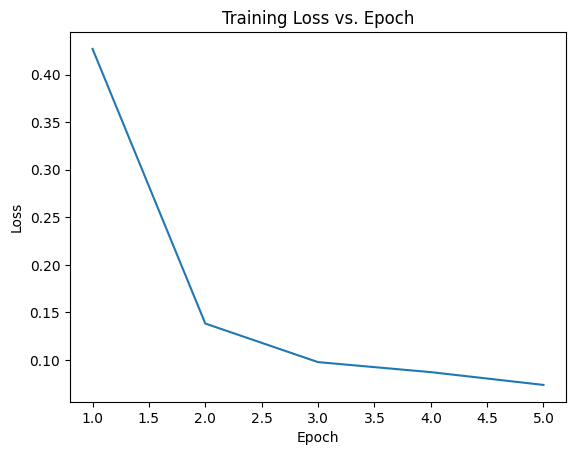

In [9]:
 #plot loss/epoch graph
plt.plot(range(1, epoch_num+1), all_train_losses)
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training Loss vs. Epoch')
plt.show()